## Credit Card Fraud Detection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("../data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

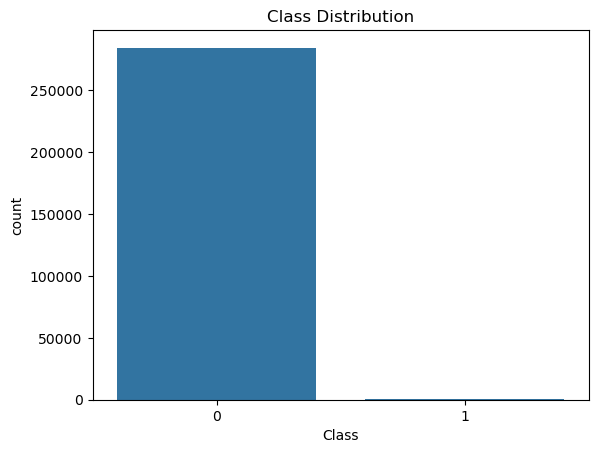

In [5]:
sns.countplot(x='Class', data=df)
plt.title("Class Distribution")
plt.show()

In [6]:
df = df.drop(columns=['Time'])

In [7]:
#feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

In [8]:
fraud = df[df['Class'] == 1]
normal = df[df['Class'] == 0].sample(n=20000, random_state=42)

df_sample = pd.concat([fraud, normal]).sample(frac=1, random_state=42)

In [9]:
X = df_sample.drop('Class', axis=1)
y = df_sample['Class']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [13]:
lr = LogisticRegression()
lr.fit(X_train_res, y_train_res)

y_pred_lr = lr.predict(X_test)
print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      4001
           1       0.45      0.91      0.60        98

    accuracy                           0.97      4099
   macro avg       0.72      0.94      0.79      4099
weighted avg       0.98      0.97      0.98      4099

ROC-AUC: 0.9683012920239328


logistic regression achieved high recall but has poor precision due to linear decision boundaries
now we will try to implement random forest, which captures non linear relationships

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=40,
    max_depth=8,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_res, y_train_res)


,n_estimators,40
,criterion,'gini'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4001
           1       0.92      0.85      0.88        98

    accuracy                           0.99      4099
   macro avg       0.96      0.92      0.94      4099
weighted avg       0.99      0.99      0.99      4099

ROC-AUC: 0.9781534208284662


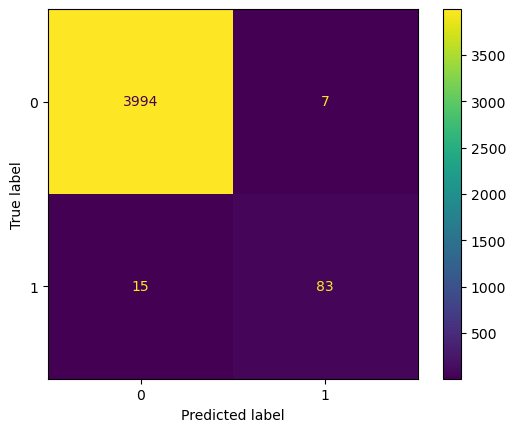

In [16]:
#confusion matrix 
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.show()

In [17]:
import numpy as np
from sklearn.metrics import precision_recall_curve

y_scores = rf.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Let's inspect some threshold options
for t in [0.5, 0.4, 0.3, 0.2]:
    y_pred_adj = (y_scores >= t).astype(int)
    
    from sklearn.metrics import classification_report
    print(f"\nThreshold: {t}")
    print(classification_report(y_test, y_pred_adj))


Threshold: 0.5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4001
           1       0.92      0.85      0.88        98

    accuracy                           0.99      4099
   macro avg       0.96      0.92      0.94      4099
weighted avg       0.99      0.99      0.99      4099


Threshold: 0.4
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4001
           1       0.76      0.89      0.82        98

    accuracy                           0.99      4099
   macro avg       0.88      0.94      0.91      4099
weighted avg       0.99      0.99      0.99      4099


Threshold: 0.3
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4001
           1       0.47      0.89      0.61        98

    accuracy                           0.97      4099
   macro avg       0.73      0.93      0.80      4099
weighted avg       0.98   

0.4 recall - detects 90% frauds
accuracy still remains stable

In [18]:
BEST_THRESHOLD = 0.4

In [19]:
import joblib

model_package = {
    "model": rf,
    "scaler": scaler,
    "threshold": BEST_THRESHOLD
}

joblib.dump(model_package, "../model/fraud_model.pkl")

print("Model, scaler, and threshold saved successfully!")

Model, scaler, and threshold saved successfully!


we will copy a real row from your dataset so prediction is meaningful

In [23]:
row = df.drop("Class", axis=1).iloc[0]
print(",".join(map(str, row.values)))

-1.3598071336738,-0.0727811733098497,2.53634673796914,1.37815522427443,-0.338320769942518,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.311169353699879,1.46817697209427,-0.470400525259478,0.207971241929242,0.0257905801985591,0.403992960255733,0.251412098239705,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.128539358273528,-0.189114843888824,0.133558376740387,-0.0210530534538215,0.24496426337017327


now lets test with fraud transactions

In [24]:
fraud_row = df[df["Class"] == 1].drop("Class", axis=1).iloc[0]
print(",".join(map(str, fraud_row.values)))

-2.3122265423263,1.95199201064158,-1.60985073229769,3.9979055875468,-0.522187864667764,-1.42654531920595,-2.53738730624579,1.39165724829804,-2.77008927719433,-2.77227214465915,3.20203320709635,-2.89990738849473,-0.595221881324605,-4.28925378244217,0.389724120274487,-1.14074717980657,-2.83005567450437,-0.0168224681808257,0.416955705037907,0.126910559061474,0.517232370861764,-0.0350493686052974,-0.465211076182388,0.320198198514526,0.0445191674731724,0.177839798284401,0.261145002567677,-0.143275874698919,-0.35322939296682354
